## Imports and Utility Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import windows
sns.set_context('notebook'); sns.set_style('white')

def generate_range_profile(num_range_bins=256, noise_level=0.05, targets=None):
    profile = np.random.randn(num_range_bins) * noise_level
    if targets:
        for t in targets:  # each t: (range_bin, amplitude, width)
            r, a, w = t
            gauss = a * np.exp(-0.5 * ((np.arange(num_range_bins) - r) / w)**2)
            profile += gauss
    return np.clip(profile, 0, None)

def generate_range_doppler(num_range=128, num_doppler=64, noise_level=0.02, targets=None):
    heatmap = np.random.randn(num_range, num_doppler) * noise_level
    if targets:
        for t in targets:  # (r, d, amp, r_width, d_width)
            r, d, a, rw, dw = t
            rg = np.exp(-0.5 * ((np.arange(num_range) - r) / rw)**2)[:, None]
            dg = np.exp(-0.5 * ((np.arange(num_doppler) - d) / dw)**2)[None, :]
            heatmap += a * rg * dg
    heatmap = np.clip(heatmap, 0, None)
    # Normalize
    heatmap /= (heatmap.max() + 1e-9)
    return heatmap

def plot_range_profile(profile, title='Range Profile'):
    plt.figure(figsize=(8,3))
    plt.plot(profile)
    plt.title(title)
    plt.xlabel('Range Bin')
    plt.ylabel('Amplitude')
    plt.grid(alpha=0.3)
    plt.show()

def plot_heatmap(hm, title='Range-Doppler Heatmap'):
    plt.figure(figsize=(6,5))
    sns.heatmap(hm, cmap='inferno')
    plt.title(title)
    plt.xlabel('Doppler Bin')
    plt.ylabel('Range Bin')
    plt.show()

## Scenario Generation: Empty Room, Metal Object, Clutter

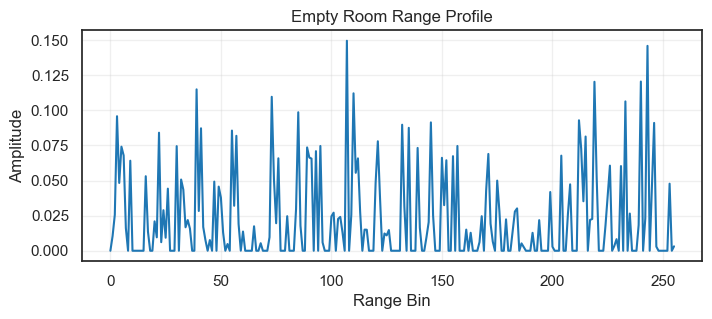

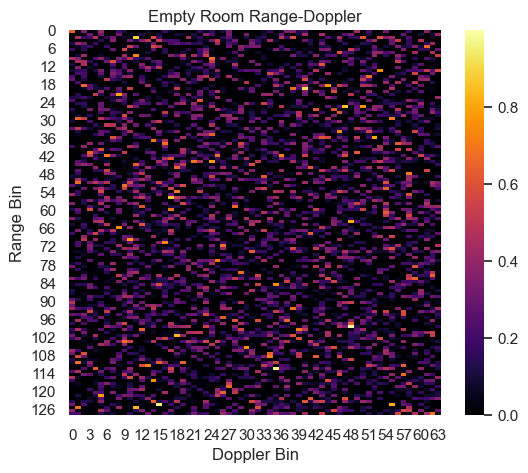

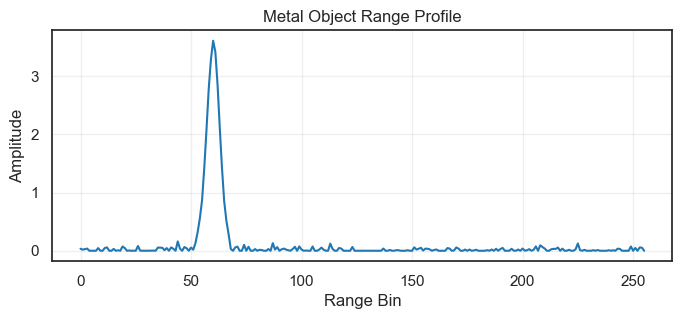

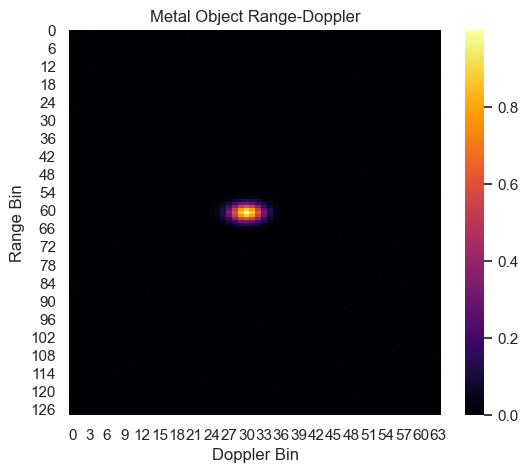

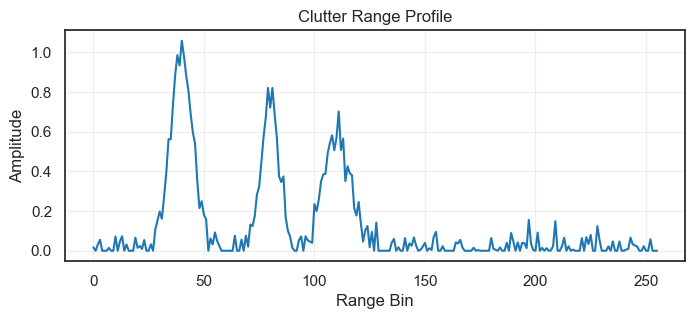

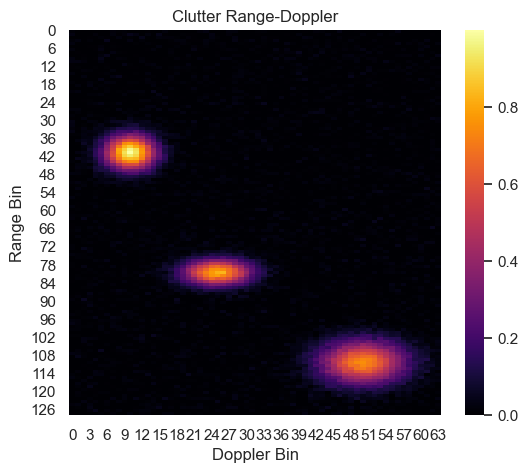

In [2]:
# Empty room (low noise floor)
empty_profile = generate_range_profile(targets=None)
plot_range_profile(empty_profile, 'Empty Room Range Profile')
empty_heatmap = generate_range_doppler(targets=None)
plot_heatmap(empty_heatmap, 'Empty Room Range-Doppler')

# Metal object (strong localized return)
metal_targets_1d = [(60, 3.5, 3)]  # range bin 60
metal_profile = generate_range_profile(targets=metal_targets_1d)
plot_range_profile(metal_profile, 'Metal Object Range Profile')
metal_targets_2d = [(60, 30, 5.0, 2, 2)]  # (r,d,amp,rw,dw)
metal_heatmap = generate_range_doppler(targets=metal_targets_2d)
plot_heatmap(metal_heatmap, 'Metal Object Range-Doppler')

# Clutter (multiple moderate reflections)
clutter_targets_1d = [(40, 1.0, 5), (80, 0.8, 4), (110, 0.6, 6)]
clutter_profile = generate_range_profile(targets=clutter_targets_1d)
plot_range_profile(clutter_profile, 'Clutter Range Profile')
clutter_targets_2d = [(40, 10, 1.2, 4, 3), (80, 25, 1.0, 3, 4), (110, 50, 0.9, 5, 5)]
clutter_heatmap = generate_range_doppler(targets=clutter_targets_2d)
plot_heatmap(clutter_heatmap, 'Clutter Range-Doppler')

## FFT-Based Transformation Demo (Synthetic Chirps)

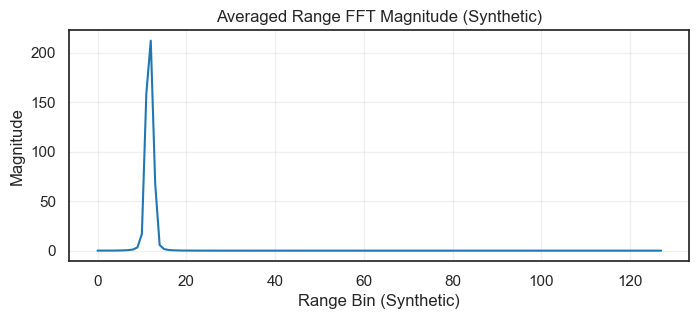

In [3]:
# Simulate raw chirp samples from targets and apply range FFT
def simulate_raw_chirps(num_chirps=32, samples_per_chirp=256, targets=None, noise=0.01):
    t = np.linspace(0, 1, samples_per_chirp, endpoint=False)
    data = np.zeros((num_chirps, samples_per_chirp), dtype=np.complex128)
    for c in range(num_chirps):
        signal = np.zeros(samples_per_chirp)
        if targets:
            for r_bin, amp, _w in targets:
                freq = (r_bin / samples_per_chirp) * 50  # synthetic mapping
                signal += amp * np.cos(2 * np.pi * freq * t)
        signal += noise * np.random.randn(samples_per_chirp)
        window = windows.hann(samples_per_chirp)
        fft_out = np.fft.fft(signal * window)
        data[c] = fft_out
    return data

raw = simulate_raw_chirps(targets=metal_targets_1d)
range_fft_mag = np.abs(raw.mean(axis=0))[:128]
plt.figure(figsize=(8,3))
plt.plot(range_fft_mag)
plt.title('Averaged Range FFT Magnitude (Synthetic)')
plt.xlabel('Range Bin (Synthetic)')
plt.ylabel('Magnitude')
plt.grid(alpha=0.3)
plt.show()

## Summary
We generated synthetic radar-like range profiles and range-Doppler heatmaps for multiple scenarios and demonstrated a simple FFT pipeline. These outputs will be used for dataset synthesis in the classification task.